In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


<AxesSubplot:>

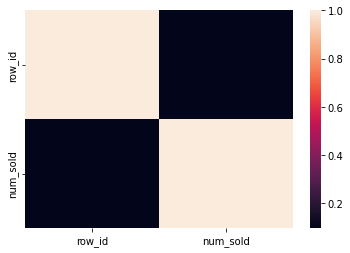

In [2]:
train_set=pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
#sns.pairplot(train,hue='num_sold')
sns.heatmap(train_set.corr())

In [3]:

train_set.isnull().sum().sum()  #null check

#train_set=train_set.set_index('date')
train_set['date']=pd.to_datetime(train_set['date'])
print(train_set.dtypes)
print(train_set.head(15))
print(max(train_set.date))
print(min(train_set.date))


row_id               int64
date        datetime64[ns]
country             object
store               object
product             object
num_sold             int64
dtype: object
    row_id       date  country       store                           product  \
0        0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1        1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2        2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3        3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4        4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   
5        5 2017-01-01  Belgium  KaggleRama            Kaggle Getting Started   
6        6 2017-01-01  Belgium  KaggleRama                Kaggle Recipe Book   
7        7 2017-01-01  Belgium  KaggleRama  Kaggle for Kids: One Smart Goose   
8        8 2017-01-01   France  KaggleMart        Kaggle Advanced Techniques   
9        9 2017-01-01   

In [4]:
color_pal=sns.color_palette()
plt.style.use('fivethirtyeight')
import plotly.express as px

df1 = train_set.query("product=='Kaggle Advanced Techniques'")
fig = px.line(df1, x="date", y="num_sold", title='Sales Plot 1')
fig.show()
df2 = train_set.query("product=='Kaggle Getting Started'")
fig = px.line(df2, x="date", y="num_sold", title='Sales Plot 2')
fig.show()
df3 = train_set.query("product=='Kaggle Recipe Book'")
fig = px.line(df2, x="date", y="num_sold", title='Sales Plot 3')
fig.show()
df3 = train_set.query("product=='aggle for Kids: One Smart Goose'")
fig = px.line(df2, x="date", y="num_sold", title='Sales Plot 4')
fig.show()

plt.show()

In [5]:
train_set=train_set.set_index('date')
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=4,test_size=365*1,gap=0)
train_set=train_set.sort_index()

print(train_set.head())

            row_id  country       store                           product  \
date                                                                        
2017-01-01       0  Belgium  KaggleMart        Kaggle Advanced Techniques   
2017-01-01       1  Belgium  KaggleMart            Kaggle Getting Started   
2017-01-01       2  Belgium  KaggleMart                Kaggle Recipe Book   
2017-01-01       3  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
2017-01-01       4  Belgium  KaggleRama        Kaggle Advanced Techniques   

            num_sold  
date                  
2017-01-01       663  
2017-01-01       615  
2017-01-01       480  
2017-01-01       710  
2017-01-01       240  


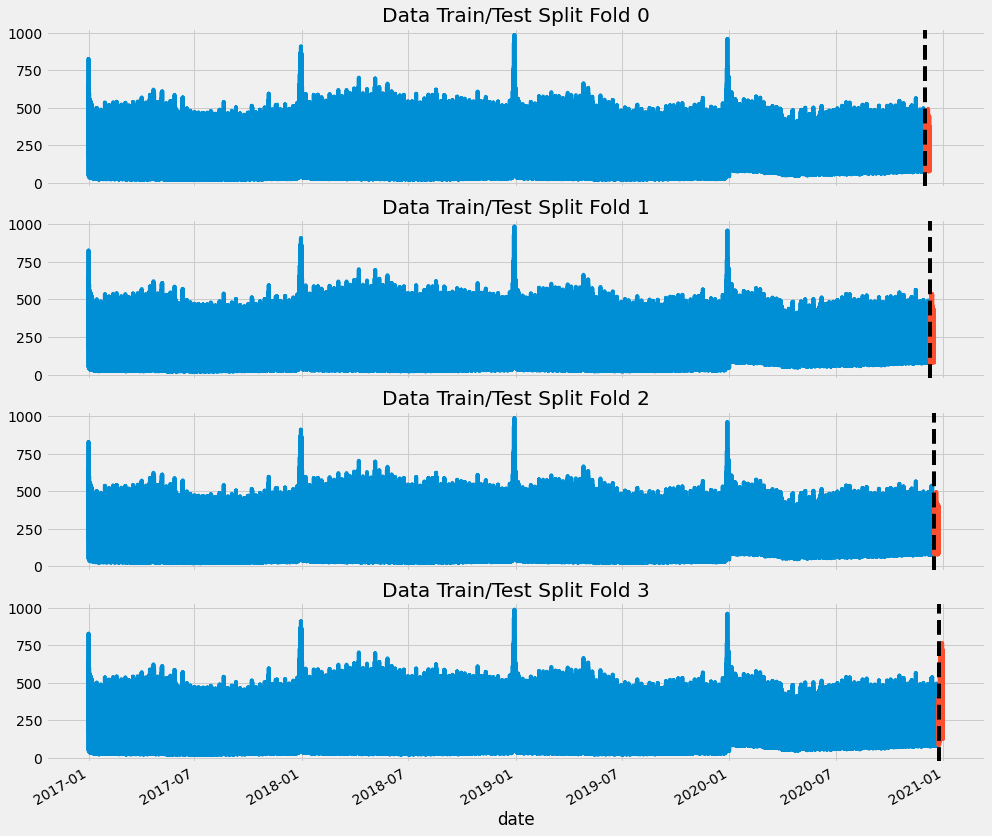

In [6]:
fig, axs = plt.subplots(4, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train_set):
    train = train_set.iloc[train_idx]
    test = train_set.iloc[val_idx]
    train['num_sold'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['num_sold'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [7]:
def create_features(train_set):
    """
    Create time series features based on time series index.
    """
    train_set = train_set.copy()
    #train_set['hour'] = train_set.index.hour
    train_set['dayofweek'] = train_set.index.dayofweek
    train_set['quarter'] = train_set.index.quarter
    train_set['month'] = train_set.index.month
    train_set['year'] = train_set.index.year
    train_set['dayofyear'] = train_set.index.dayofyear
    train_set['dayofmonth'] = train_set.index.day
    #train_set['weekofyear'] = train_set.index.isocalendar().week
    return train_set

train_set = create_features(train_set)


In [8]:
def add_lags(train_set):
    target_map = train_set['num_sold'].to_dict()
    train_set['lag1'] = (train_set.index - pd.Timedelta('366 days')).map(target_map)
    train_set['lag2'] = (train_set.index - pd.Timedelta('730 days')).map(target_map)
    train_set['lag3'] = (train_set.index - pd.Timedelta('1093 days')).map(target_map)
    train_set['lag4'] = (train_set.index - pd.Timedelta('1457 days')).map(target_map)
    return train_set

train_set = add_lags(train_set)

In [9]:
tss = TimeSeriesSplit(n_splits=4, test_size=365*1, gap=0)
train_set = train_set.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(train_set):
    train = train_set.iloc[train_idx]
    test = train_set.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['lag1','lag2','lag3','lag4']
    TARGET = 'num_sold'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=200,
                           early_stopping_rounds=300,
                           objective='reg:squarederror',
                           max_depth=30,
                           learning_rate=0.01,
                           colsample_bytree=0.5)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:228.55647	validation_1-rmse:250.78817
[100]	validation_0-rmse:143.00189	validation_1-rmse:144.09873
[199]	validation_0-rmse:126.99785	validation_1-rmse:121.89194
[0]	validation_0-rmse:228.67968	validation_1-rmse:262.67535
[100]	validation_0-rmse:143.00914	validation_1-rmse:159.24000
[199]	validation_0-rmse:126.97639	validation_1-rmse:134.22864
[0]	validation_0-rmse:228.87024	validation_1-rmse:253.63041
[100]	validation_0-rmse:143.05435	validation_1-rmse:148.89293
[199]	validation_0-rmse:126.98559	validation_1-rmse:126.18035
[0]	validation_0-rmse:229.00652	validation_1-rmse:375.52883
[100]	validation_0-rmse:143.07175	validation_1-rmse:243.48465
[199]	validation_0-rmse:126.97119	validation_1-rmse:205.90121


In [10]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 147.0505
Fold scores:[121.89193770218525, 134.22863921833462, 126.18034710806187, 205.90121548045894]


In [11]:
train_set = create_features(train_set)

#FEATURES = ['dayofyear', 'month','year','dayofweek','quarter','dayofmonth',
               # 'lag1','lag2','lag3','lag4']
FEATURES = ['lag1','lag2','lag3','lag4']
TARGET = 'num_sold'

X_all = train_set[FEATURES]
y_all = train_set[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=80,
                       objective='reg:squarederror',
                       max_depth=30,
                       learning_rate=0.01,
                       colsample_bytree=0.5)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:230.00578
[79]	validation_0-rmse:152.47612


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=30, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [12]:
fi = pd.DataFrame({'Importance':reg.feature_importances_,'Name':reg.feature_names_in_})
print(fi)

   Importance  Name
0    0.162951  lag1
1    0.124197  lag2
2    0.329240  lag3
3    0.383612  lag4


In [13]:
# Create future dataframe
test_set=pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')
print(test_set.head())
test_set['date']=pd.to_datetime(test_set['date'])
test_set=test_set.set_index('date')
test_set['isFuture'] = True
train_set['isFuture'] = False
test_n_train = pd.concat([train_set, test_set])
test_n_train = create_features(test_n_train)
test_n_train = add_lags(test_n_train)

print(test_n_train.tail(15))

future_w_features = test_n_train.query('isFuture').copy()
future_w_features['num_sold'] = reg.predict(future_w_features[FEATURES])

   row_id        date  country       store                           product
0   70128  2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129  2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130  2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131  2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132  2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques
            row_id country       store                           product  \
date                                                                       
2021-12-31   87633  Poland  KaggleMart            Kaggle Getting Started   
2021-12-31   87634  Poland  KaggleMart                Kaggle Recipe Book   
2021-12-31   87635  Poland  KaggleMart  Kaggle for Kids: One Smart Goose   
2021-12-31   87636  Poland  KaggleRama        Kaggle Advanced Techniques   
2021-12-31   87637  Poland  KaggleRama            Kaggle Getting Started   
2021-1

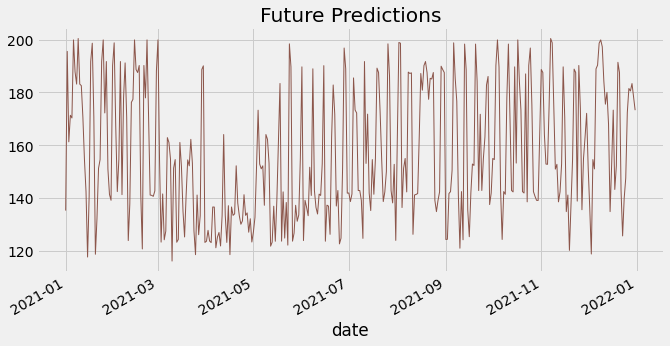

In [14]:
future_w_features['num_sold'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

In [15]:
future_w_features_1 = future_w_features[future_w_features['isFuture']==True]
print(future_w_features_1.head(15))
output = pd.DataFrame({'row_id': future_w_features_1.row_id, 'num_sold':future_w_features_1.num_sold })
output.to_csv('submission.csv', index=False)

            row_id  country       store                           product  \
date                                                                        
2021-01-01   70128  Belgium  KaggleMart        Kaggle Advanced Techniques   
2021-01-01   70129  Belgium  KaggleMart            Kaggle Getting Started   
2021-01-01   70130  Belgium  KaggleMart                Kaggle Recipe Book   
2021-01-01   70131  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
2021-01-01   70132  Belgium  KaggleRama        Kaggle Advanced Techniques   
2021-01-01   70133  Belgium  KaggleRama            Kaggle Getting Started   
2021-01-01   70134  Belgium  KaggleRama                Kaggle Recipe Book   
2021-01-01   70135  Belgium  KaggleRama  Kaggle for Kids: One Smart Goose   
2021-01-01   70136   France  KaggleMart        Kaggle Advanced Techniques   
2021-01-01   70137   France  KaggleMart            Kaggle Getting Started   
2021-01-01   70138   France  KaggleMart                Kaggle Recipe Book   

In [16]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [17]:
base_accuracy = evaluate(reg, X_test, y_test)



Model Performance
Average Error: 169.5149 degrees.
Accuracy = 59.79%.
